<a href="https://colab.research.google.com/github/JLopez86/plant_disease/blob/main/04_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#4. Transferencia de Aprendizaje

##4.1. Instalación de Requerimientos

In [1]:
# Instalación del cliente Neptune
! pip install neptune-client[fastai]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.7/439.7 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 39.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.

In [ ]:
# Importación de librerías
from google.colab import files
from google.colab import drive
from fastai.vision.all import *
import os
import shutil
import torch
import random
#from fastai.callback.tensorboard import TensorBoardCallback
from fastai.callback.hook import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#print('matplotlib: {}'.format(matplotlib.__version__))

# Importación de librerías para integración Fastai | Neptune
import neptune.new as neptune
from neptune.new.integrations.fastai import NeptuneCallback

#from nbdev.showdoc import show_doc

# Verificación de activación de GPU
print(torch.cuda.is_available())

True


In [ ]:
# Montar el drive y extraer el conjunto de datos
drive.mount('/content/drive')
# Descomprimir imágenes para entrenamiento y validación
! unzip /content/drive/MyDrive/Colab\ Notebooks/DPI\ -\ Anomalias\ en\ Hojas/Plant_Disease.zip
# Descomprimir imágenes para pruebas
! unzip /content/drive/MyDrive/Colab\ Notebooks/DPI\ -\ Anomalias\ en\ Hojas/Validation.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Colab Notebooks/DPI - Anomalias en Hojas/Plant_Disease.zip
   creating: Plant_Disease/
   creating: Plant_Disease/Healthy/
  inflating: Plant_Disease/Healthy/94b531898979f38b.jpg  
  inflating: Plant_Disease/Healthy/97f3cad16524509b.jpg  
  inflating: Plant_Disease/Healthy/83f7381b7cace01c.jpg  
  inflating: Plant_Disease/Healthy/86c8358db7d560ad.jpg  
  inflating: Plant_Disease/Healthy/8e6a823cce9ff40c.jpg  
  inflating: Plant_Disease/Healthy/85edd994308a6f65.jpg  
  inflating: Plant_Disease/Healthy/84f60a857fb26bc1.jpg  
  inflating: Plant_Disease/Healthy/818a15d52bb75f0e.jpg  
  inflating: Plant_Disease/Healthy/9f2174f703ca3961.jpg  
  inflating: Plant_Disease/Healthy/88d8c872ceb7a2b6.jpg  
  inflating: Plant_Disease/Healthy/90c790666f674f58.jpg  
  inflating: Plant_Disease/Healthy/93a7c1dd2fe04f20.jpg  
  inflating: Plant_Disease/Healthy/98d2ed0b33c866d9.jpg  
  inflating: Plant_Disease/Healthy/8bda74e18b458f0d.jpg  
  infl

##4.2. Definición del Conjunto de Datos

In [ ]:
# Cargar el conjunto de datos en memoria
path = 'Plant_Disease'
files = get_image_files(path)

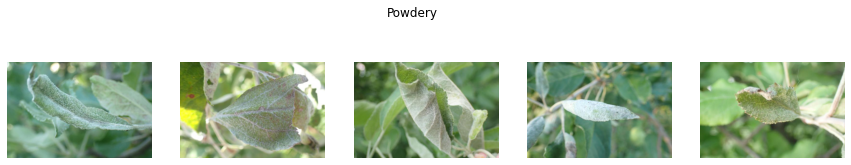

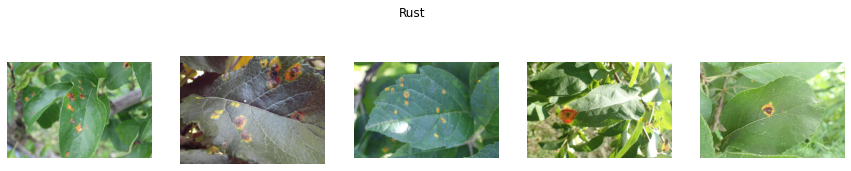

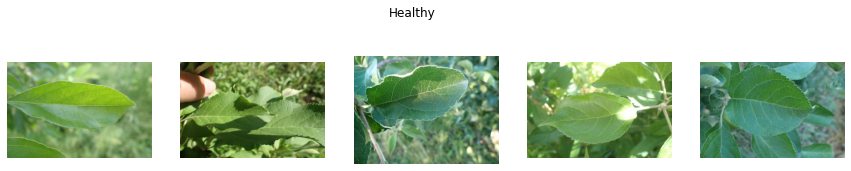

In [ ]:
# Etiquetas del dataset y visualización de las muestras
labels = os.listdir(path)
dataset = {}
for label in labels:
  images = get_image_files(path, folders=label)
  dataset[label] =len(images)
  sample = [load_image(image) for image in images.shuffle()[:5]]
  show_images(sample, nrows=1, ncols=5, imsize=3, suptitle=label)

In [ ]:
# Definición de funciones
# Cargar el conjunto de datos y distribuir para entrenamiento y validación
def get_imgDataLoaders(val = 0.2, bt=224, tr=False, bs = 64):
  return ImageDataLoaders.from_folder(path, files, valid_pct=val, item_tfms=[Resize(bt)], batch_tfms= aug_transforms(size=224), pretrained=tr, device=torch.device('cuda'), bs = bs)

In [ ]:
# Cargar el conjunto de datos y distribuir para entrenamiento y validación
dls = get_imgDataLoaders()

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


RuntimeError: ignored

In [ ]:
dls.show_batch()

##4.3. Entrenamiento del Modelo

In [ ]:
#learn = vision_learner(dls, resnet34, metrics=accuracy)
#learn = vision_learner(dls, resnet101, metrics=accuracy)
#learn = vision_learner(dls, resnet34, path='/content/', model_dir='models', metrics=[accuracy, error_rate], cbs=ActivationStats(with_hist=True))
# Modelos: mobilenet_v3_large   wd=None
def set_learner():
  return vision_learner(dls, resnet34, path='/content/', model_dir='models', metrics=[accuracy, error_rate], cbs=ActivationStats(with_hist=True), wd_bn_bias=False)

learner = set_learner()

In [ ]:
learner.summary()

/usr/local/lib/python3.8/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 192 x 56 x 56  
Conv2d                                    110592     False     
BatchNorm2d                               384        True      
____________________________________________________________________________
                     64 x 192 x 28 x 28  
MaxPool2d                                   

SuggestedLRs(valley=0.0008317637839354575)

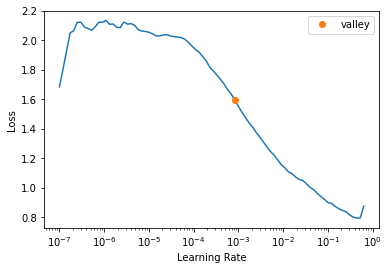

In [ ]:
lr = learner.lr_find()
lr

In [ ]:
learner.fine_tune(1, lr[0])

In [ ]:
lr[0] - (lr[0] * 35 / 100)

0.001129570504417643

In [ ]:
# Definición de Hyperparametros
epochs = 3
modelo_list = [resnet34, googlenet, mobilenet_v3_large]
bs_list = [32,64,128]
lr_list = [0.1, 0.01, lr[0]]

def set_learner():
  return vision_learner(dls, googlenet, path='/content/', model_dir='models', metrics=[accuracy, error_rate], cbs=ActivationStats(with_hist=True))

learner = set_learner()

In [ ]:
# Entrenando del modelo y registrando en Neptune
#dls, googlenet, path='/content/', model_dir='models', metrics=[accuracy, error_rate], cbs=ActivationStats(with_hist=True)
for bs in [64]: 
  run = neptune.init_run(
      api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4ODA3ZGE2OC0wNzI4LTRlYjMtYjQ2YS0xZDk1NTVjNmY2OTMifQ==",
      project="jlopez.tics/Plants-Disease")
  neptune_callback = NeptuneCallback(run=run)
  dls = get_imgDataLoaders(bs = bs)
  learn = vision_learner(dls, googlenet, metrics=[accuracy, error_rate], cbs=ActivationStats(with_hist=True), loss_func=CrossEntropyLossFlat())
  learn.fit_one_cycle(2, lr[0], cbs=neptune_callback)
  run.stop()

https://app.neptune.ai/jlopez.tics/Plants-Disease/e/PLAN-27
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


##4.4. Intepretación de Resultados

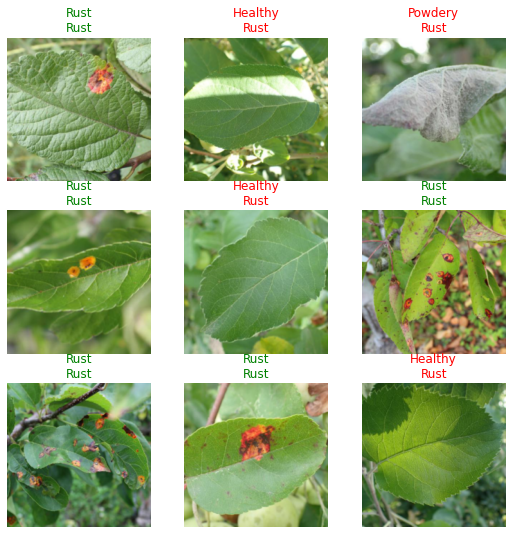

In [ ]:
learner.show_results()

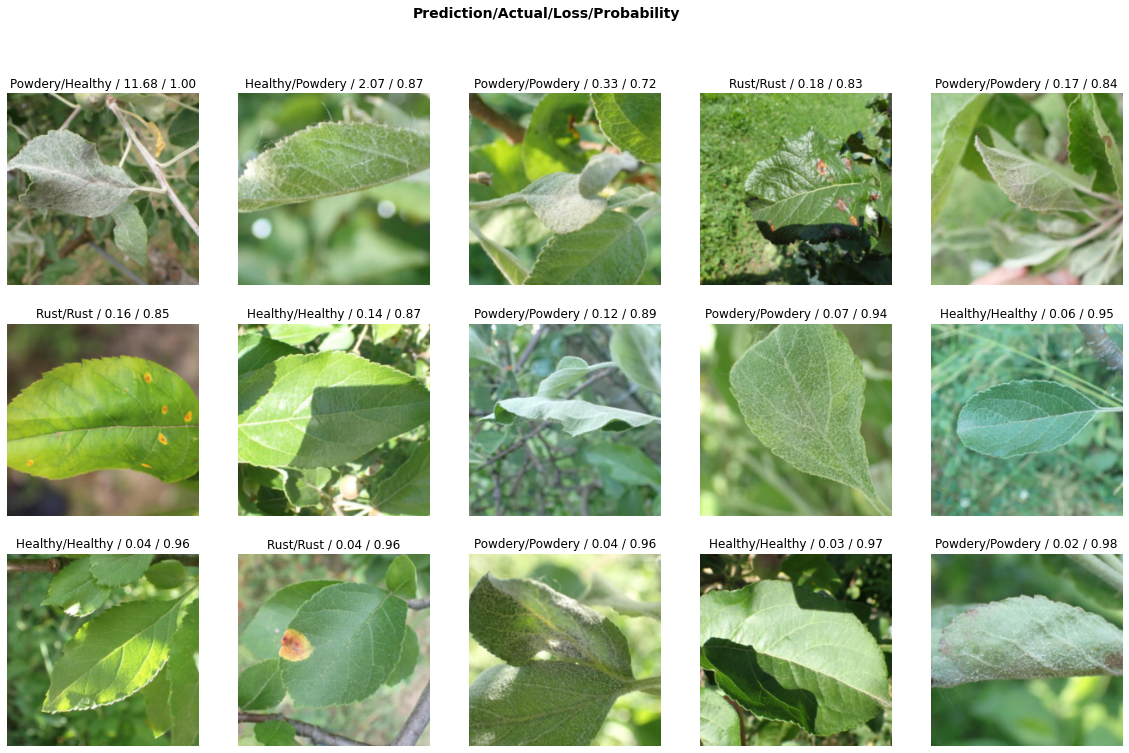

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(15, figsize=(20,12))

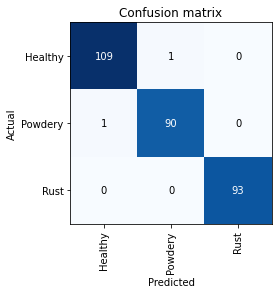

In [ ]:
cinterp = ClassificationInterpretation.from_learner(learn)
cinterp.plot_confusion_matrix()

##4.5. Predicción

In [ ]:
# Función para predecir imagen
def pred_img(img_path):
  dirs = os.listdir(path)
  dirs.copy()
  dirs.sort()
  img = PILImage.create(img_path)
  pred,c,probs = learn.predict(img)
  print('-'*95)
  print(f" Predicción: {pred}.")
  print(f" Probabilidad: {probs[c].item()*100:.2f}%")
  print('-'*95)
  figura = plt.figure(figsize = (12,3))
  figura.subplots_adjust(hspace=1.5, wspace=0.5)
  grafico1 = figura.add_subplot(121)
  grafico2 = figura.add_subplot(122)
  grafico1.imshow(img)
  grafico2.bar(dirs, probs.tolist(), width=.85)
  grafico1.set_title('Visualización de la Imagen')
  grafico2.set_title('Probabilidad de clases')
  grafico2.set_ylabel('Probabilidad 0 - 1')
  grafico2.set_xlabel('Etiquetas / Clases')
  plt.show()

In [ ]:
# Función para predecir imagen
def pred_img(img_path, learner):
  dirs = os.listdir(path)
  dirs.copy()
  dirs.sort()
  img = PILImage.create(img_path)
  pred,c,probs = learner.predict(img)
  print('-'*95)
  print(f" Predicción: {pred}.")
  print(f" Probabilidad: {probs[c].item()*100:.2f}%")
  print('-'*95)
  figura = plt.figure(figsize = (12,3))
  figura.subplots_adjust(hspace=1.5, wspace=0.5)
  grafico1 = figura.add_subplot(121)
  grafico2 = figura.add_subplot(122)
  grafico1.imshow(img)
  grafico2.bar(dirs, probs.tolist(), width=.85)
  grafico1.set_title('Visualización de la Imagen')
  grafico2.set_title('Probabilidad de clases')
  grafico2.set_ylabel('Probabilidad 0 - 1')
  grafico2.set_xlabel('Etiquetas / Clases')
  plt.show()

In [ ]:
# Predecir una imagen en concreto
img_path = '/content/Validation/Healthy/9bdcc23296db1516.jpg'
pred_img(img_path, adam_32)

In [ ]:
# Predecir una imagen en concreto
img_path = '/content/Validation/Powdery/8fc5721dc2f293c1.jpg'
pred_img(img_path)

NameError: ignored

##4.6. Próximas acciones